<a href="https://www.kaggle.com/code/suartas/spark-timeseries-regression-taxi-cnt-predict-by-h?scriptVersionId=142677805" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

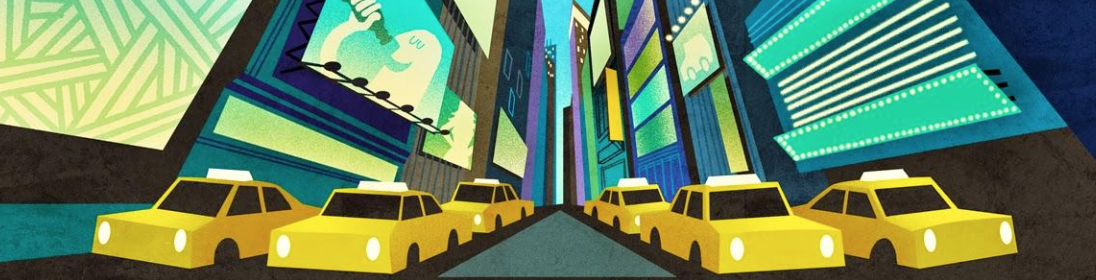

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip3 install pyspark

# Цель проекта

**Описание:** В нашем распоряжении около 10 млн записей о поездках такси в
Чикаго и перед нами стоит задача предсказать количество заказов
на следующий час в каждом округе. Решать будем с
применением PySpark.

**Цель проекта:**
Построить ML модель на Spark предсказания
количества заказов на следующий час для каждого района

**Исходные данные:**

■ Данные за 2022 год:
https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz

■ Данные за 2023 год:
https://data.cityofchicago.org/Transportation/Taxi-Trips-2023/e55j-2ewb


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import seaborn as sns

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.window import Window
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StringType, ShortType, IntegerType, TimestampType, LongType, StructType, StructField, DoubleType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pandas.tseries.holiday import USFederalHolidayCalendar

from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

from xgboost.spark import SparkXGBRegressor
from prophet import Prophet
from statsmodels.graphics import tsaplots


from tqdm import tqdm
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.plotting.backend = "plotly"

In [ ]:
#constant
RANDOM_STATE = 42
TRAIN_SIZE = 0.8
LIM22 = '2022-12-31 23:00'

## Описание данных

- Trip ID - A unique identifier for the trip.
- Taxi ID - A unique identifier for the taxi.
- Trip Start Timestamp - When the trip started, rounded to the nearest 15 minutes.
- Trip End Timestamp - When the trip ended, rounded to the nearest 15 minutes.
- Trip Seconds - Time of the trip in seconds.
- Trip Miles - Distance of the trip in miles.
- Pickup Census Tract - The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.
- Dropoff Census Tract - The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.
- Pickup Community Area - The Community Area where the trip began. This column will be blank for locations outside Chicago.
- Dropoff Community Area -The Community Area where the trip ended. This column will be blank for locations outside Chicago.
- Fare - The fare for the trip.
- Tips -The tip for the trip. Cash tips generally will not be recorded.
- Tolls -The tolls for the trip.
- Extras - Extra charges for the trip.
- Trip Total - Total cost of the trip, the total of the previous columns.
- Payment Type - Type of payment for the trip.
- Company -The taxi company.

# 1. Загружаем и преобразуем данные

**Источник данных**

https://data.cityofchicago.org/Transportation/Taxi-Trips-2022/npd7-ywjz

In [ ]:
spark = SparkSession.builder.appName('taxi').getOrCreate()
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
spark.sparkContext.setLogLevel("ERROR")

In [ ]:
#use your url
file_path_1 = '/kaggle/input/taxi-trips-2022-v-2/Taxi_Trips_-_2022.csv'

In [ ]:
try:
    df = spark.read.csv(file_path_1,
                    header = True,
                    inferSchema = True,
                    nanValue = '').cache()

except FileNotFoundError:
    print("File not found.")

**Размер датафрейма**

In [ ]:
(df.count(), len(df.columns))

## 1.1. Структура данных

In [ ]:
df.printSchema()

## 1.2. Изменяем наименование колонок

In [ ]:
df = df.toDF(*['_'.join(i.lower().split()) for i in df.columns])

In [ ]:
df.columns

## 1.2. Проверяем на пропуски

In [ ]:
df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

## 1.3. Изменяем тип данных базовых признаков

In [ ]:
df = df.withColumn('trip_start_timestamp', F.to_timestamp(F.col('trip_start_timestamp'), 'MM/dd/yyyy hh:mm:ss a'))
df = df.withColumn('trip_end_timestamp', F.to_timestamp(F.col('trip_end_timestamp'), 'MM/dd/yyyy hh:mm:ss a'))
df = df.withColumn("pickup_community_area", F.col("pickup_community_area").cast("int"))
df = df.withColumn("dropoff_community_area",F. col("dropoff_community_area").cast("int"))

In [ ]:
df.limit(5).toPandas()

**Минимальная дата и максимальная дата**

In [ ]:
t = df.agg(F.min('trip_start_timestamp').alias('min_date'), F.max('trip_start_timestamp').alias('max_date'))
t.show()

In [ ]:
min_start_date = t.head()[0]
max_start_date = t.head()[1]

In [ ]:
min_start_date, max_start_date

## 1.4. Удаляем признаки

In [ ]:
columns_to_drop = [ 'trip_id', 'taxi_id', 'pickup_centroid_latitude', 'pickup_centroid_longitude',
                   'pickup_centroid_longitude', 'pickup_centroid_longitude', 'pickup_centroid_longitude',
                   'pickup_centroid_longitude', 'dropoff_centroid_longitude', 'dropoff_centroid_location',
                   'pickup_centroid_location', 'pickup_centroid_location', 'dropoff_centroid_latitude',
                    'pickup_census_tract', 'dropoff_census_tract', 'company', 'payment_type', 'fare', 'tips',
                   'tolls', 'extras','trip_total']
df = df.drop(*columns_to_drop)

In [ ]:
df.show(10)

## 1.5. Создаем area где null

In [ ]:
df = df.na.fill(99,subset=["pickup_community_area"])
df = df.na.fill(98,subset=["dropoff_community_area"])

**Посмотрим на количество районов**

In [ ]:
df.select(F.countDistinct("pickup_community_area")).show()

In [ ]:
df.select("pickup_community_area").distinct().show()

# 2. EDA

## 2.1. Количество заказов по районам

In [ ]:
t = df.groupBy("pickup_community_area").count().toPandas()
t = t.sort_values(by='count',ascending=False)
t['pickup_community_area'] = t['pickup_community_area'].astype('str')

In [ ]:
t.head(10)

In [ ]:
fig = px.bar(t, y='pickup_community_area', x='count',
              title='Количество заказов по районам',
              labels={
                     "pickup_community_area": "Район",
                     "count": "Количество"
                 },
              width=1200,
              height=700,
              orientation='h')
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

In [ ]:
t = df.groupby(F.date_trunc('hour', F.col('trip_start_timestamp')).alias('hour')) \
                                                     .agg(F.count('*').alias('cnt_target')) \
                                                     .toPandas()

t = t.set_index('hour')


fig = px.line(t, t.index, y="cnt_target",
              title='Количество заказов в день',
              labels={
                     "cnt_target": "Количество заказов",
                     "hour": "час"
                 },
              width=1400,
              height=600)


fig.show()

In [ ]:
t

In [ ]:
fig = px.box(t, x="pickup_community_area",
             y="count",
             title='Box-plot заказов по районам')
fig.show()

По количеству заказов разброс очень большой. Есть районы с большим количество есть с маленьким.

## 2.2. Количество заказов по дню по всем районам

In [ ]:
t = df.groupby(F.date_trunc('day', F.col('trip_start_timestamp')).alias('start_date')) \
                                                     .agg(F.count('*').alias('cnt_target')) \
                                                     .orderBy('start_date') \
                                                     .toPandas()

t = t.set_index('start_date')


fig = px.line(t, t.index, y="cnt_target",
              title='Количество заказов в день',
              labels={
                     "cnt_target": "Количество заказов",
                     "start_date": "Дата"
                 },
              width=1400,
              height=600)


fig.show()

Из графика виден тренд к лету увеличивается количество заказов, а также сезонность по неделям

## 2.3. Количество заказов по дню по районам

In [ ]:
t = df.groupBy('pickup_community_area', F.date_trunc('day', F.col('trip_start_timestamp')).alias('date'))\
                                                                 .agg(F.count('*').alias('count')) \
                                                                 .orderBy('date') \
                                                                 .toPandas()

t = t.set_index('date')

fig = px.line(t, t.index, y="count",
              title='Количество заказов по районам',
              labels={
                     "date": "Дата",
                     "count": "Количество"
                 },
              color = 'pickup_community_area',
              width=1400,
              height=600)
fig.show()

Распределение по районам приблизительно одинаковые

**Посмотрим на маленькие районы по которым мало данных:**

In [ ]:
s = set([11, 53, 5, 2, 3])

fig = px.line(t[t.pickup_community_area.isin(s)], t[t.pickup_community_area.isin(s)].index, y="count",
              title='Количество заказов для районов с маленьким количеством заказов',
              labels={
                     "x": "Дата",
                     "count": "Количество"
                 },
              color = 'pickup_community_area',
              width=1400,
              height=600)
fig.show()

## 2.4. Количество заказов по месяцам по районам

In [ ]:
t = df.groupBy('pickup_community_area', F.month(F.col("trip_start_timestamp")).alias('month')) \
                                                                     .agg(F.count('*').alias('count')) \
                                                                     .toPandas().set_index('month') \
                                                                     .sort_values(by=['month', 'count'], \
                                                                                  ascending=[True, True])

fig = px.bar(t, y=t.index, x='count',
              title='Количество заказов по месяцам',
              labels={
                     "count": "Количество",
                     "month": "Месяц"
                 },
              width=1200,
              height=600,
              color='pickup_community_area',
              orientation='h')
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

В общем количество заказов по районам не меняется от месяца к месяцу

## 2.5. Недельная сезонность

In [ ]:
t = df.filter(F.month(F.col("trip_start_timestamp")) == 4).groupBy(F.date_trunc('day', F.col('trip_start_timestamp'))
                                                                 .alias('date'))\
                                                                 .agg(F.count('*').alias('count')) \
                                                                 .orderBy('date') \
                                                                 .toPandas()

t = t.set_index('date')

In [ ]:
fig = px.line(t, t.index, y="count",
              title='Количество заказов в апреле',
              labels={
                     "date": "Дата",
                     "count": "Количество"
                 },
              width=1400,
              height=600)
fig.show()

Видим еженедельную сезонность

In [ ]:
def plot_seasonal_decompose(result:DecomposeResult, dates:pd.Series=None, title:str="Seasonal Decomposition"):
    x_values = dates if dates is not None else np.arange(len(result.observed))
    return (
        make_subplots(
            rows=4,
            cols=1,
            subplot_titles=["Observed", "Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.observed, mode="lines", name='Observed'),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.trend, mode="lines", name='Trend'),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.seasonal, mode="lines", name='Seasonal'),
            row=3,
            col=1,
        )
        .add_trace(
            go.Scatter(x=x_values, y=result.resid, mode="lines", name='Residual'),
            row=4,
            col=1,
        )
        .update_layout(
            height=900, title=f'<b>{title}</b>', margin={'t':100}, title_x=0.5, showlegend=False
        )
    )

In [ ]:
decomposition = seasonal_decompose(t['count'], model='additive')
fig = plot_seasonal_decompose(decomposition, dates=t.index)
fig.show()

## 2.6. Количество заказов в течение недели

In [ ]:
t = df.filter((F.month(F.col("trip_start_timestamp")) == 3) & (F.date_format(F.col("trip_start_timestamp"), "W")==2)) \
                                .groupBy(F.date_trunc('hour', F.col('trip_start_timestamp')).alias('hour')) \
                                .agg(F.count('*').alias('count')) \
                                .orderBy('hour') \
                                .toPandas().set_index('hour')

In [ ]:
fig = px.line(t, t.index, y="count",
              title='Количество заказов по дню недели',
              labels={
                     "hour_trip_start_timestamp": "Дата",
                     "count": "Количество"
                 },
              width=1400,
              height=600)
fig.show()

In [ ]:
decomposition = seasonal_decompose(t['count'], model='additive')
fig = plot_seasonal_decompose(decomposition, dates=t.index)
fig.show()

Из графика видно дневную сезонность

## 2.7. TSA

Построим график автокорреляционной функции

In [ ]:
t = df.groupby(F.date_trunc('day', F.col('trip_start_timestamp')).alias('start_date')) \
                                                     .agg(F.count('*').alias('cnt_target')) \
                                                     .orderBy('start_date') \
                                                     .toPandas()

In [ ]:
ts = t['cnt_target']

plt.figure(figsize=(12,10))
fig = tsaplots.plot_acf(ts,lags= 200)
fig.set_size_inches(18.5, 6)
plt.ylim(-.4, 1.1)
plt.title("Autocorrelation")
plt.show()

## 2.5 Выводы

По результатам проведенного EDA выявили следующее:

- Распределения количества заказов по районам очень сильно отличается
- Есть тренд к лету
- Есть дневная сезонность 
- Есть недельная сезонность

# 3. Feature Engineering

## 3.1. Создаем Range из даты начала и окончания

In [ ]:
def generate_series(start, stop, interval) -> DataFrame:
    """
    :param start  - lower bound, inclusive
    :param stop   - upper bound, exclusive
    :interval int - increment interval in seconds
    
    """

    start, stop = spark.createDataFrame(
        [(start, stop)], ("start", "stop")
    ).select(
        [F.col(c).cast("timestamp").cast("long") for c in ("start", "stop")
    ]).first()
    return spark.range(start, stop, interval).select(
        F.col("id").cast("timestamp").alias("ds")
    )

In [ ]:
min_start_date, max_start_date

In [ ]:
generate_series(min_start_date, max_start_date, 60 * 60).show(5)
date_range_t = generate_series(min_start_date, max_start_date, 60 * 60)

In [ ]:
date_range_t.printSchema()

In [ ]:
#check
date_range_t.toPandas().set_index('ds').index.is_monotonic_increasing

In [ ]:
date_range_t.toPandas().head(5)

## 3.2.  Функция создания новых признаков и фильтрации по району

In [ ]:
def create_buckets(df_t: DataFrame, date_range_t: DataFrame, area: int) -> DataFrame :
    """
    """
    
    # filtering and creating data
    df_area = df_t.filter(df_t.pickup_community_area == area).groupby(F.date_trunc('hour', F.col('trip_start_timestamp')).alias('start_date_hour')) \
                                                                                                                         .agg(F.count('*').alias('y')) \
                                                                                                                         .orderBy('start_date_hour')    
    
    #Join 2 DF range and main
    df_area = date_range_t.join(df_area, date_range_t.ds == df_area.start_date_hour, "left")
    
    #Fill y with 0
    df_area = df_area.na.fill(value=0, subset=["y"])
    
    #Add features day_of_week, hour, month, week_of_month
    df_area = df_area.withColumn("day_of_week",F.dayofweek(F.col("ds")))
    df_area = df_area.withColumn("hour",F.hour(F.col("ds")))
    #df_area = df_area.withColumn("month",F.month(F.col("ds")))
    #df_area = df_area.withColumn("week_of_month", F.date_format(F.col("ds"), "W"))
    
    #Add sin cos hour
    
    df_area = df_area.withColumn('sin_hour', F.sin(2*np.pi * F.col('hour')/24))
    df_area = df_area.withColumn('cos_hour', F.cos(2*np.pi * F.col('hour')/24))
    
    
    #Add Holidas features
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2022-01-01', end='2024-01-01').to_pydatetime()
    holidays = set([str(datetime.datetime.date(i)) for i in holidays])
    holidayUDF = F.udf(lambda x: 1 if str(datetime.datetime.date(x)) in holidays else 0, ShortType())
    
    df_area = df_area.withColumn('holiday', holidayUDF(F.col('ds')))
    
#     #Add Befor Holiday feature
#     w = Window().partitionBy().orderBy('ds')
#     df_area = df_area.withColumn("befor_holiday", F.lag(F.col('holiday'), -1).over(w).cast("short"))
    
#     #Add After Holiday feature
#     w = Window().partitionBy().orderBy('ds')
#     df_area = df_area.withColumn("after_holiday", F.lag(F.col('holiday'), 1).over(w).cast("short"))
    
    #Add Lags
    w = Window().partitionBy().orderBy('ds')

    for i in range(1, 24 + 1):
        df_area = df_area.withColumn(f"lag_{i}", F.lag(F.col('y'), i).over(w).cast("integer"))


    w = Window().partitionBy().orderBy('ds')

    for i in range(24, 24*8, 24):
        df_area = df_area.withColumn(f"lag_{i}", F.lag(F.col('y'), i).over(w).cast("integer"))
    
    #Rolling mean
    cumulative_window = Window().partitionBy().orderBy('ds').rowsBetween(-24,0)
    df_area = df_area.withColumn('roll_24_mean', F.avg('y').over(cumulative_window))

    #Drop NA Columns
    df_area = df_area.drop('start_date_hour')
    df_area = df_area.drop('hour')
    df_area = df_area.na.drop()

    return df_area

In [ ]:
#test area
AREA = 33

In [ ]:
df_a = create_buckets(df, date_range_t, AREA)

In [ ]:
df_a.limit(5).toPandas()

### 3.2. Приводим к типам данных

In [ ]:
def change_data_type(df_t: DataFrame) -> DataFrame:

    df_t = df_t.withColumn("y",F.col("y").cast("integer"))
    df_t = df_t.withColumn("day_of_week",F.col("day_of_week").cast("integer"))
    #df_t = df_t.withColumn("hour",F.col("hour").cast("integer"))
    #df_t = df_t.withColumn("month",F.col("month").cast("integer"))
    df_t = df_t.withColumn("holiday",F.col("holiday").cast("integer"))

    return df_t

In [ ]:
df_a = change_data_type(df_a)

# 4. Models

## 4.1. Feature Vector Assembler

In [ ]:
FEATURE_LIST = list(df_a.columns)
FEATURE_LIST.remove('y')
FEATURE_LIST.remove('ds')
FEATURE_LIST

In [ ]:
def feature_vector_assembler(df_t: DataFrame,feature_list: list) -> DataFrame:
    """
    """
    featureassembler = VectorAssembler(inputCols=feature_list,
                                   outputCol="independent")
    output = featureassembler.transform(df_t)
    final_data = output.select("independent", "y", "ds")
    
    return final_data

In [ ]:
#hist
#df_a_t = df_a.alias('df_a_t')
#id(df_a_t) == id(df_a)  # False

df_a = feature_vector_assembler(df_a, FEATURE_LIST)

In [ ]:
df_a.show()

## 4.2 Train/val/test split

In [ ]:
def train_val_test_split(df_t: DataFrame, train_size: int) -> DataFrame:

    df_t = df_t.withColumn("rank", F.percent_rank().over(Window.partitionBy().orderBy("ds")))
    #df_t = df_t.withColumn('index', F.monotonically_increasing_id())
    
    train = df_t.filter(F.col("rank") <= train_size).drop('rank')
    val = df_t.filter(F.col("rank") > train_size).drop('rank')
    test = val.tail(1)
    val = val.filter(F.to_timestamp(F.col('ds'), 'MM/dd/yyyy hh:mm:ss a')<LIM22)

    return train, val, test

In [ ]:
train, val, test = train_val_test_split(df_a, TRAIN_SIZE)

In [ ]:
test = spark.createDataFrame(data=test)
test.show()

In [ ]:
#check len
(train.count(), len(train.columns)), (val.count(), len(val.columns))

## 4.3. Метрики. Создадим функции для подсчета метрик

In [ ]:
def mae(y_true, y_pred):
    mae = np.abs(y_true - y_pred)
    
    return float(mae)

mae = F.udf(mae, DoubleType())

In [ ]:
def smape(y_true, y_pred):
    smape = (np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true)))/2)*100
    
    return float(smape)

smape = F.udf(smape, DoubleType())

## 4.4. Prothet

In [ ]:
model_prophet = Prophet(
      interval_width=0.95,
      changepoint_prior_scale=0.5,
      seasonality_prior_scale=10,
      daily_seasonality=True,
      weekly_seasonality=True,
      seasonality_mode='multiplicative'
    )

model_prophet.add_country_holidays(country_name='US')

model_prophet.fit(train.select('y','ds').toPandas())

In [ ]:
@pandas_udf(DoubleType())
def prohet_func(y: pd.Series, ds: pd.Series) -> pd.Series:  
    
    future = model_prophet.make_future_dataframe(
        periods=len(y),
        freq='H',
        include_history=False)
    
    future = model_prophet.predict(future)
    future['yhat'] = future['yhat'].clip(lower=0)
        
    return future['yhat']

In [ ]:
predict = val.select(F.col('y'), F.col('ds'), prohet_func(F.col('y'), F.col('ds')).alias('yhat'))

In [ ]:
predict = predict.withColumn('mae', mae('y', 'yhat'))
predict = predict.withColumn('smape', smape('y', 'yhat'))
predict.show()

In [ ]:
t = predict.toPandas().set_index('ds')
fig = go.Figure()
fig.add_trace(go.Scatter(x=t.index, y=t.y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=t.index, y=t.yhat,
                    mode='lines',
                    name='yhat'))

fig.update_traces(line={'width': 1})
fig.show()

In [ ]:
score_list = list()
score_list.append(('Prophet', 'mae', predict.select(F.mean('mae')).toPandas()['avg(mae)'].values[0]))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

## 4.5. LinearRegression

In [ ]:
model_l_reg = LinearRegression(featuresCol='independent',
                               maxIter = 100,
                               labelCol='y',
                               regParam = 0.4,
                               elasticNetParam = 0.1
                               )

In [ ]:
model_l_reg = model_l_reg.fit(train)

Посмотрим на коэффициенты, чтобы небыло аномальных

In [ ]:
model_l_reg.coefficients, model_l_reg.intercept

In [ ]:
predict = model_l_reg.transform(val)

In [ ]:
predict = predict.withColumn('mae', mae('y', 'prediction'))
predict = predict.withColumn('smape', smape('y', 'prediction'))
predict.show()

In [ ]:
# predict_t = model_l_reg.transform(test)
# predict_t = predict_t.withColumn('mae', mae('y', 'prediction'))
# predict_t.show()

In [ ]:
t = predict.toPandas().set_index('ds')
fig = go.Figure()
fig.add_trace(go.Scatter(x=t.index, y=t.y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=t.index, y=t.prediction,
                    mode='lines',
                    name='prediction'))

fig.update_traces(line={'width': 1})
fig.show()

In [ ]:
score_list.append(('LinearRegression', 'mae', predict.select(F.mean('mae')).toPandas()['avg(mae)'].values[0]))
score_list.append(('LinearRegression', 'smape', predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

Метрики на валидационной выборке на линейной регрессии гораздо лучше prophet

## 4.6. RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(featuresCol="independent",
                            labelCol="y",
                            maxDepth=12,
                            numTrees=100,
                            subsamplingRate=0.8,
                            seed=RANDOM_STATE)
model_rf = rfr.fit(train)

In [ ]:
predict = model_rf.transform(val)

In [ ]:
predict = predict.withColumn('mae', mae('y', 'prediction'))
predict = predict.withColumn('smape', smape('y', 'prediction'))
predict.show()

In [ ]:
t = predict.toPandas().set_index('ds')
fig = go.Figure()
fig.add_trace(go.Scatter(x=t.index, y=t.y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=t.index, y=t.prediction,
                    mode='lines',
                    name='prediction'))

fig.update_traces(line={'width': 1})
fig.show()

In [ ]:
score_list.append(('RandomForestRegressor', 'mae', predict.select(F.mean('mae')).toPandas()['avg(mae)'].values[0]))
score_list.append(('RandomForestRegressor', 'smape', predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

**Важность признаков RandomForestRegressor**

In [ ]:
pd.DataFrame({'feature': FEATURE_LIST,
              'importance': model_rf.featureImportances.toArray()
             }).sort_values(by='importance', ascending=False)

## 4.7. XGBRegressor

In [ ]:
sparkXGBregressor = SparkXGBRegressor(max_depth=7,
                                      num_workers=3,
                                      n_estimators=100,
                                      features_col='independent',
                                      label_col='y',
                                      seed=RANDOM_STATE
                                      )

In [ ]:
model_xgb = sparkXGBregressor.fit(train)

In [ ]:
predict = model_xgb.transform(val)
predict = predict.withColumn('mae', mae('y', 'prediction'))
predict = predict.withColumn('smape', smape('y', 'prediction'))
predict.show()

In [ ]:
t = predict.toPandas().set_index('ds')
fig = go.Figure()
fig.add_trace(go.Scatter(x=t.index, y=t.y,
                    mode='lines',
                    name='y'))
fig.add_trace(go.Scatter(x=t.index, y=t.prediction,
                    mode='lines',
                    name='prediction'))
fig.update_traces(line={'width': 1})
fig.show()

In [ ]:
score_list.append(('XGBRegressor', 'mae', predict.select(F.mean('mae')).toPandas()['avg(mae)'].values[0]))
score_list.append(('XGBRegressor', 'smape', predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

**Важность признаков XGBRegressor**

In [ ]:
pd.DataFrame({'feature': FEATURE_LIST,
              'importance': model_xgb.get_booster().get_score(importance_type='gain').values()
             }).sort_values(by='importance', ascending=False)

**Grid Search XGBRegressor**

In [ ]:
# depth = [5, 6, 7]
# n_estimators = [75, 100, 150, 200, 250]
# gs_results = []
# for d in depth:
#     for e in n_estimators:
#         sparkXGBregressor = SparkXGBRegressor(max_depth=d,
#                                       num_workers=3,
#                                       n_estimators=e,
#                                       features_col='independent',
#                                       label_col='y')
        
#         model_xgb = sparkXGBregressor.fit(train)
        
        
#         predict = model_xgb.transform(val)
#         predict = predict.withColumn('smape', smape('y', 'prediction'))
#         gs_results.append((d, e, predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))
#
#gs_results

## 4.8. GBTRegressor

In [ ]:
gbt = GBTRegressor(featuresCol='independent',
                   labelCol='y',
                   maxDepth=7,
                   seed=RANDOM_STATE)

In [ ]:
model_gbt = gbt.fit(train)

In [ ]:
predict = model_gbt.transform(val)
predict = predict.withColumn('mae', mae('y', 'prediction'))
predict = predict.withColumn('smape', smape('y', 'prediction'))
predict.show()

# evaluator = RegressionEvaluator(predictionCol='prediction',
#                                 labelCol='y',
#                                 metricName = 'mae')

In [ ]:
score_list.append(('GBTRegressor', 'mae', predict.select(F.mean('mae')).toPandas()['avg(mae)'].values[0]))
score_list.append(('GBTRegressor', 'smape', predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))
pd.DataFrame(score_list, columns=['Model','Metric','Score'])

**Grid Search GBTRegressor**

In [ ]:
# depth = [5, 6, 7, 8]
# gs_results = []
# for d in depth:
    
#         gbt = GBTRegressor(featuresCol='independent', labelCol='y', maxDepth=d)
#         model_gbt = gbt.fit(train)
#         predict = model_gbt.transform(val)
#         predict = predict.withColumn('smape', smape('y', 'prediction'))
#         gs_results.append((d, predict.select(F.mean('smape')).toPandas()['avg(smape)'].values[0]))

# gs_results

## Выводы

По результатам проведенного моделирования для выборочного района (средний район по количеству заказов) - лучшим алгоритмом оказался SparkXGBRegressor, на втором месте GBTRegressor. Бустинговые методы предпочтительнее в данной задаче.
Построим на основе данного алгоритма модели для остальных районов.

# 6. Строим модели для всех районов

In [ ]:
#get all areas
areas_df = df.select("pickup_community_area").distinct().toPandas()
areas = areas_df.pickup_community_area.values

In [ ]:
areas

In [ ]:
#!!! Ограничил выборку т.к. для всех районов периодически падает по jvm памяти
areas = np.array([31, 65, 22, 24, 28, 32, 1, 3, 5, 6, 7, 14, 17, 77, 43, 44, \
                  55,  2, 60, 62, 70, 73, 75, 11, 71, 99], dtype='int32')
areas

In [ ]:
score_list_areas = []
models_dict = dict()

for i in tqdm(areas):

    #create features
    df_a = create_buckets(df, date_range_t, i).cache()
    
    #change types
    df_a = change_data_type(df_a)
    
    #feature_vector_assembler
    df_a = feature_vector_assembler(df_a, FEATURE_LIST)
    
    #train val split
    train, val, _ = train_val_test_split(df_a, TRAIN_SIZE)
    
    #define model sparkXGBregressor
    sparkXGBregressor = SparkXGBRegressor(max_depth=7,
                                          num_workers=3,
                                          n_estimators=75,
                                          features_col='independent',
                                          label_col='y',
                                          seed=RANDOM_STATE)
    
    model_xgb = sparkXGBregressor.fit(train)
    
    #add model to dict
    models_dict.setdefault(f'area_{i}', model_xgb)
    
    #predict
    predict = model_xgb.transform(val)
    predict = predict.withColumn('mae', mae('y', 'prediction'))
    predict = predict.withColumn('smape', smape('y', 'prediction'))
    
    score_list_areas.append((i, 'mae', predict.select(F.mean('mae')) \
                             .toPandas()['avg(mae)'].values[0]))
    score_list_areas.append((i, 'smape', predict.select(F.mean('smape')) \
                             .toPandas()['avg(smape)'].values[0]))
    print(f'-> Model for area {i} fitted. Score -> ', score_list_areas[-2] ,score_list_areas[-1])

In [ ]:
final_results = pd.DataFrame(score_list_areas, columns=['Area', 'Metric_val','Score'])
t = final_results.set_index(['Area','Metric_val']).unstack(level=0)
t.columns = [i[1] for i in t.columns]

In [ ]:
cm = sns.light_palette("green", as_cmap=True)
s = t.style.background_gradient(cmap=cm)
s

In [ ]:
final_results['Area'] = final_results['Area'].astype('str')

In [ ]:
fig = px.bar(final_results[final_results['Metric_val'] == 'mae'].sort_values(by='Score', ascending=False),
              y='Area',
              x='Score',
              title='MAE моделей по районам',
              labels={
                     "Score": "Метрика",
                     "Area": "Район"
                 },
              width=1200,
              height=700,
              orientation='h')
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

In [ ]:
fig = px.bar(final_results[final_results['Metric_val'] == 'smape'].sort_values(by='Score', ascending=False),
              y='Area',
              x='Score',
              title='SMAPE моделей по районам',
              labels={
                     "Score": "Метрика",
                     "Area": "Район"
                 },
              width=1200,
              height=700,
              orientation='h')
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

# 7. Выводы

Мы провели исследовательский анализ данных, выявили закономерности-сезонности в данных.
Рассмотрели и построили модели на следующих алгоритмах: Prophet, LinearRegression, RandomForestRegressor, XGBRegressor, GBTRegressor, выбрали лучший алгоритм - XGBRegressor. 

Получили следующие метрики:


**Cредняя MAE по районам на валидационной выборке:**

In [ ]:
final_results[final_results['Metric_val'] == 'mae']['Score'].mean()

**Cредняя SMAPE по районам на валидационной выборке:**

In [ ]:
final_results[final_results['Metric_val'] == 'smape']['Score'].mean()


**Для улучшения метрик по районам можно проверить следующие гипотезы:**
    
1. Продолжить работу и убирать низкоинформативные признаки
2. Для каждого района строить модель со своими гиперпараметрами, добавив в пайплан поиск гиперпараметров (пробовал по времени очень долго)
2. Для районов с разреженными данными и для районов где много заказов попробовать отличные алгоритмы
3. Кластеризировать районы и модели строить не по районам а по выделенным кластерам
4. Обучить prothet или arima на трейне и использовать предсказания как фитчи
5. Проверить алгоритм arima 

Проверим модели на тесте:

In [ ]:
predict_t = model_xgb.transform(test)
predict_t = predict_t.withColumn('mae', mae('y', 'prediction'))
predict_t.show()

In [ ]:
for k, v in models_dict.items():
    
    df_a = create_buckets(df, date_range_t, i).cache()
    df_a = change_data_type(df_a)
    df_a = feature_vector_assembler(df_a, FEATURE_LIST)
    
    #train val split
    _, _, test = train_val_test_split(df_a, TRAIN_SIZE)
    model_xgb = models_dict.get(k)
    test = spark.createDataFrame(data=test)
    predict_t = model_xgb.transform(test)
    predict_t = predict_t.withColumn('mae', mae('y', 'prediction'))
    print(predict_t.select(F.col('mae')).collect())

## 4.7. Prothet + XGBRegressor 

In [ ]:
# df_a_t.limit(5).toPandas()

In [ ]:
# AREA

# df_a = create_buckets(df, date_range_t, AREA)
# df_a = change_data_type(df_a)

In [ ]:
# df_a_t.limit(5).toPandas()

In [ ]:
#train val split
#train, val, test = train_val_test_split(df_a_t, 0.8)

In [ ]:
# train.limit(5).toPandas()

In [ ]:
# model_prophet = Prophet(
#       interval_width=0.95,
#       changepoint_prior_scale=0.5,
#       seasonality_prior_scale=10,
#       daily_seasonality=True,
#       weekly_seasonality=True,
#       seasonality_mode='multiplicative'
#     )

# model_prophet.add_country_holidays(country_name='US')

# model_prophet.fit(df_a_t.select('y','ds').toPandas())

In [ ]:
# @pandas_udf(DoubleType())
# def prohet_func(y: pd.Series, ds: pd.Series) -> pd.Series:  
    
#     future = model_prophet.make_future_dataframe(
#         periods=len(y),
#         freq='H',
#         include_history=False)
    
#     future = model_prophet.predict(future)
#     future['yhat'] = future['yhat'].clip(lower=0)
        
#     return future['yhat']

In [ ]:
# predict = train.select(F.col('y'), F.col('ds'), prohet_func(F.col('y'), F.col('ds')).alias('yhat'))

In [ ]:
# predict = predict.withColumn('mae', mae('y', 'yhat'))
# predict = predict.withColumn('smape', smape('y', 'yhat'))
# predict.show()

In [ ]:
# t = predict.toPandas().set_index('ds')
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=t.index, y=t.y,
#                     mode='lines',
#                     name='y'))
# fig.add_trace(go.Scatter(x=t.index, y=t.yhat,
#                     mode='lines',
#                     name='yhat'))

# fig.update_traces(line={'width': 1})
# fig.show()

In [ ]:
# predict.limit(5).toPandas()

In [ ]:
# train.limit(5).toPandas()

In [ ]:
# train = train.select(*(F.col(x).alias(x + '_1') for x in train.columns))
# predict = predict.select(*(F.col(x).alias(x + '_2') for x in predict.columns))

In [ ]:
#  t = train.join(predict, train.ds_1_1 == predict.ds_2,"left").show()

In [ ]:
# featureassembler = VectorAssembler(inputCols=['independent_1_1','yhat_2'],
#                                    outputCol="independent")
# output = featureassembler.transform(t)
# #final_data = output.select("independent", "y", "ds")

## Cross Validation Prothet

In [ ]:
# from prophet.diagnostics import cross_validation, performance_metrics
# import itertools

In [ ]:
# # Parameter grid
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
#     'seasonality_prior_scale': [0.01, 1.0, 5, 10, 12],
#     'seasonality_mode': ['multiplicative']
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# mapes = []  # Store the MAPEs for each params here

In [ ]:
# q
# # Use cross validation to evaluate all parameters
# for params in all_params:
#     # Fit a model using one parameter combination
#     m = Prophet(**params).fit(train.select('y','ds').toPandas())
#     # Cross-validation
#     df_cv = cross_validation(m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
#     # Model performance
#     df_p = performance_metrics(df_cv, rolling_window=24)
#     # Save model performance metrics
#     mapes.append(df_p['mape'].values[0])

# # Tuning results
# best_params = all_params[np.argmin(mapes)]

# # Best parameters
# print(best_params)